Потренируемся построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import cv2

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary

import os
from torchvision.datasets import MNIST
from torchvision import transforms

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

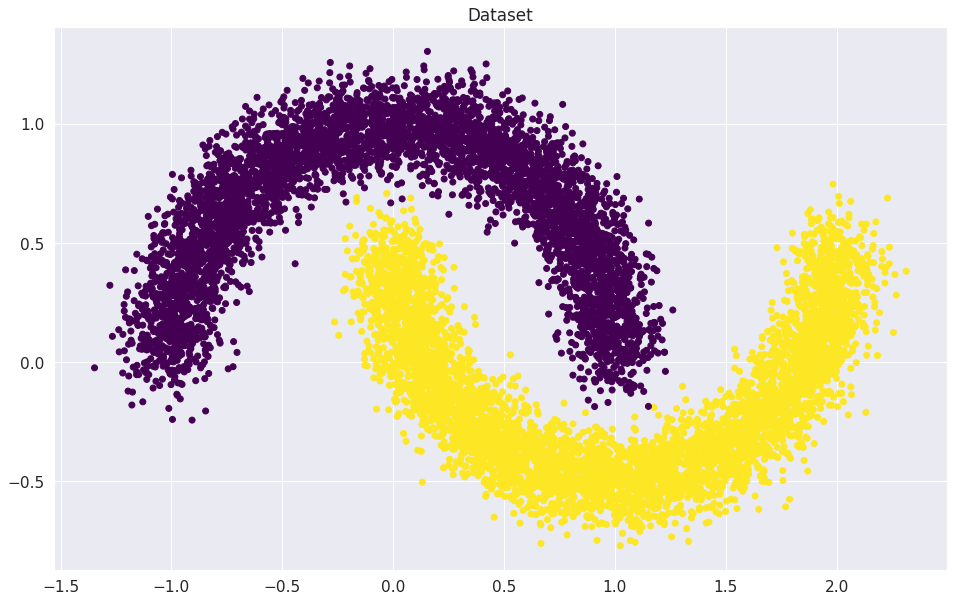

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=12345)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Создадим тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Реализация логистической регрессии

Нам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear`. Инициализируем веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):

        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [8]:
# pip install torchinfo

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Посмотрим, сколько обучаемых параметров у получившейся модели. Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [10]:
summary(linear_regression)

Layer (type:depth-idx)                   Param #
LinearRegression                         3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [11]:
sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)

3

### Реализация цикла обучения

In [15]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs): # итерируемся по датасету несколько раз
    for it, (X_batch, y_batch) in enumerate(train_dataloader): # итерируемся по датасету.
        # Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad() # обуляем градиенты модели
        outp = linear_regression(X_batch) # получаем "логиты" из модели
        loss = loss_function(outp.view(-1), y_batch) # считаем "лосс" для логистической регрессии
        loss.backward() # считаем градиенты
        losses.append(loss.detach().flatten()[0])
        optimizer.step() # делаем шаг градиентного спуска
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol: # в случае сходимости выходим из цикла
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4296875
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.78125
Iteration: 300
Batch accuracy: 0.84375
Iteration: 400
Batch accuracy: 0.828125
Iteration: 500
Batch accuracy: 0.8515625
Iteration: 600
Batch accuracy: 0.890625

Iteration: 665.Convergence. Stopping iterations.


Нам потребовалось 665 итераций, чтобы алгоритм сошелся

### Визуализируем результаты

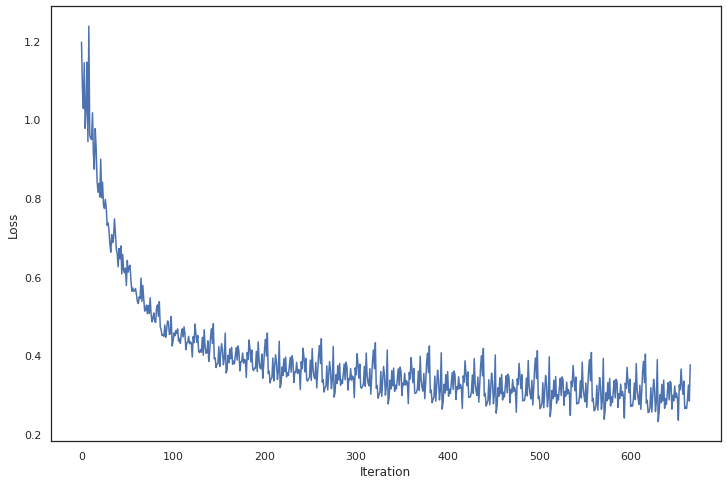

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

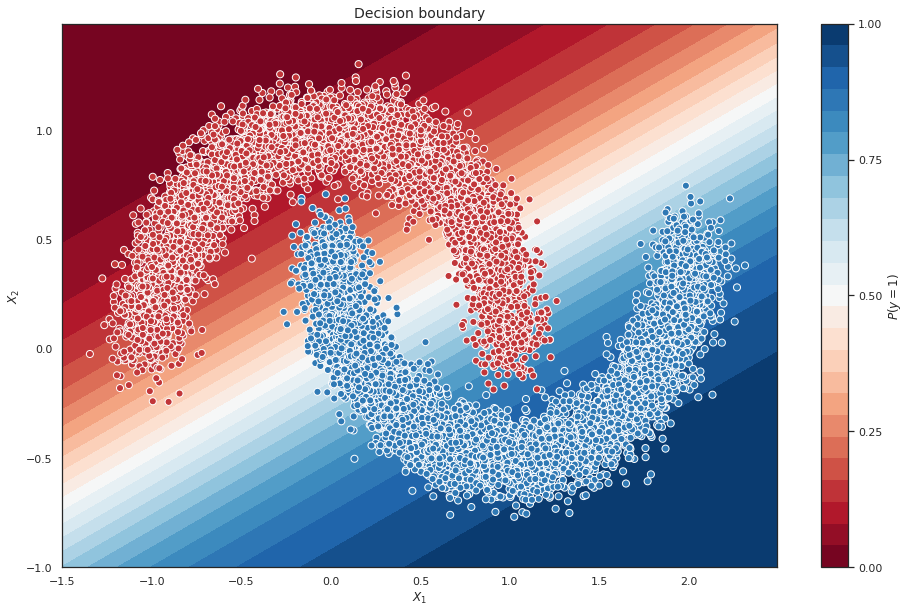

In [17]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Реализуем predict и посчитаем accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = torch.sigmoid(model(x_batch))
        preds = (outp > 0.5).type(torch.long) # Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [19]:
# Compute total accuracy
preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, preds)

0.8628

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы

In [20]:
tfs = transforms
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10,
                                          shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10,
                                          shuffle=True, num_workers=0)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [21]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть 

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Зададим лосс для обучения (кросс-энтропия).


In [22]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    # Add layers to your sequential class
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [23]:
criterion = nn.CrossEntropyLoss() # Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
torch.cuda.is_available()

True

### Цикл обучения.

In [29]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model = model.to(device)
for epoch in range(max_epochs): # итерируемся по датасету несколько раз
    for k, dataloader in loaders.items(): # несколько dataloader для train / valid / test
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader: # итерируемся по датасету.
            # Так как мы используем SGD а не GD, то берем батчи заданного размера
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train() # переводим модель в режим train
                optimizer.zero_grad()  # обнуляем градиенты модели
                outp = model(x_batch)
            else:
                 # Set model to ``eval`` mode and calculate outputs
                model.eval() # переводим модель в режим eval
                with torch.no_grad(): # НЕ считаем градиенты
                    outp = model(x_batch) # получаем "логиты" из модели
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # считаем метрики
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch) # считаем "лосс" для логистической регрессии
                # Calculate gradients and make a step of your optimizer
                loss.backward() # считаем градиенты
                optimizer.step() # делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9138166666666667
Loader: valid. Accuracy: 0.9473
Epoch: 2
Loader: train. Accuracy: 0.9540833333333333
Loader: valid. Accuracy: 0.9642
Epoch: 3
Loader: train. Accuracy: 0.9634333333333334
Loader: valid. Accuracy: 0.9628
Epoch: 4
Loader: train. Accuracy: 0.9675
Loader: valid. Accuracy: 0.9654
Epoch: 5
Loader: train. Accuracy: 0.97165
Loader: valid. Accuracy: 0.9592
Epoch: 6
Loader: train. Accuracy: 0.9735666666666667
Loader: valid. Accuracy: 0.9694
Epoch: 7
Loader: train. Accuracy: 0.9756
Loader: valid. Accuracy: 0.9673
Epoch: 8
Loader: train. Accuracy: 0.9776333333333334
Loader: valid. Accuracy: 0.9507
Epoch: 9
Loader: train. Accuracy: 0.9777
Loader: valid. Accuracy: 0.9665
Epoch: 10
Loader: train. Accuracy: 0.9805
Loader: valid. Accuracy: 0.9741


### Протестируем разные функции активации.
Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [32]:
elu_accuracy = accuracy["valid"]

In [33]:
# Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    # Add layers to your sequential class
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                     # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()  # переводим модель в режим train
                    optimizer.zero_grad()  # обнуляем градиенты модели
                    outp = model(x_batch)
                else:
                     # Set model to ``eval`` mode and calculate outputs
                    model.eval()  # <------------------ переводим модель в режим eval
                    with torch.no_grad():  # <--------- НЕ считаем градиенты
                        outp = model(x_batch)  # <------------- получаем "логиты" из модели
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum() # считаем метрики
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch) # считаем "лосс" для логистической регрессии
                    # Calculate gradients and make a step of your optimizer
                    loss.backward() # считаем градиенты
                    optimizer.step() # делаем шаг градиентного спуска
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
            
    return accuracy["valid"]

In [28]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.8615666666666667
Loader: valid. Accuracy: 0.8797
Epoch: 2
Loader: train. Accuracy: 0.8879333333333334
Loader: valid. Accuracy: 0.9033
Epoch: 3
Loader: train. Accuracy: 0.8940666666666667
Loader: valid. Accuracy: 0.9086
Epoch: 4
Loader: train. Accuracy: 0.8994333333333333
Loader: valid. Accuracy: 0.8995
Epoch: 5
Loader: train. Accuracy: 0.9035833333333333
Loader: valid. Accuracy: 0.9071
Epoch: 6
Loader: train. Accuracy: 0.9038
Loader: valid. Accuracy: 0.905
Epoch: 7
Loader: train. Accuracy: 0.9059833333333334
Loader: valid. Accuracy: 0.8971
Epoch: 8
Loader: train. Accuracy: 0.9070666666666667
Loader: valid. Accuracy: 0.9065
Epoch: 9
Loader: train. Accuracy: 0.9077
Loader: valid. Accuracy: 0.9156
Epoch: 10
Loader: train. Accuracy: 0.9089
Loader: valid. Accuracy: 0.9117


In [34]:
relu_accuracy = test_activation_function(nn.ReLU)

Epoch: 1
Loader: train. Accuracy: 0.90665
Loader: valid. Accuracy: 0.9441
Epoch: 2
Loader: train. Accuracy: 0.95145
Loader: valid. Accuracy: 0.9462
Epoch: 3
Loader: train. Accuracy: 0.9603833333333334
Loader: valid. Accuracy: 0.9641
Epoch: 4
Loader: train. Accuracy: 0.9647166666666667
Loader: valid. Accuracy: 0.9619
Epoch: 5
Loader: train. Accuracy: 0.96885
Loader: valid. Accuracy: 0.9607
Epoch: 6
Loader: train. Accuracy: 0.9715
Loader: valid. Accuracy: 0.9629
Epoch: 7
Loader: train. Accuracy: 0.9722666666666666
Loader: valid. Accuracy: 0.9639
Epoch: 8
Loader: train. Accuracy: 0.97485
Loader: valid. Accuracy: 0.9663
Epoch: 9
Loader: train. Accuracy: 0.9761
Loader: valid. Accuracy: 0.9741
Epoch: 10
Loader: train. Accuracy: 0.97705
Loader: valid. Accuracy: 0.9717


In [35]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.9048666666666667
Loader: valid. Accuracy: 0.9405
Epoch: 2
Loader: train. Accuracy: 0.9508333333333333
Loader: valid. Accuracy: 0.9613
Epoch: 3
Loader: train. Accuracy: 0.9593833333333334
Loader: valid. Accuracy: 0.9511
Epoch: 4
Loader: train. Accuracy: 0.9644
Loader: valid. Accuracy: 0.9584
Epoch: 5
Loader: train. Accuracy: 0.968
Loader: valid. Accuracy: 0.96
Epoch: 6
Loader: train. Accuracy: 0.9710166666666666
Loader: valid. Accuracy: 0.9581
Epoch: 7
Loader: train. Accuracy: 0.9738333333333333
Loader: valid. Accuracy: 0.971
Epoch: 8
Loader: train. Accuracy: 0.9745166666666667
Loader: valid. Accuracy: 0.9681
Epoch: 9
Loader: train. Accuracy: 0.9760833333333333
Loader: valid. Accuracy: 0.9712
Epoch: 10
Loader: train. Accuracy: 0.9774
Loader: valid. Accuracy: 0.9685


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

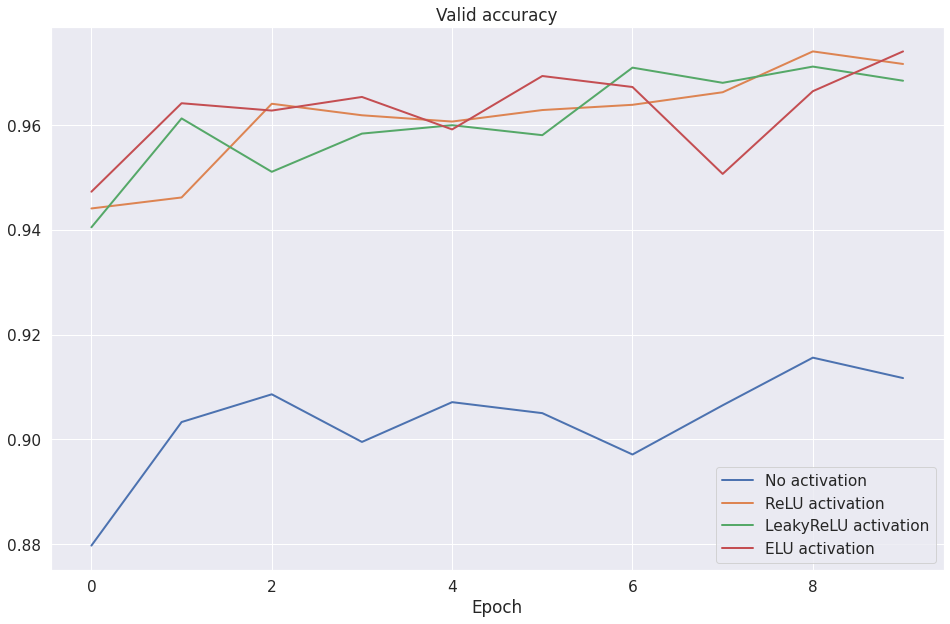

In [36]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Видим, что ELU показала наивысший `accuracy` к концу обучения.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [37]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-02-05 12:31:09--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village.kz (img.the-village.kz)… 144.76.208.75
Подключение к img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [переход]
--2023-02-05 12:31:09--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Распознаётся img.the-village-kz.com (img.the-village-kz.com)… 144.76.208.75
Подключение к img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 49337 (48K) [image/jpeg]
Сохранение в: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    за 0,09s   

2023-02-05 12:31:10 (564 KB/s) - ‘sample_

In [38]:
# pip install opencv-python

In [39]:
# pip install cv2

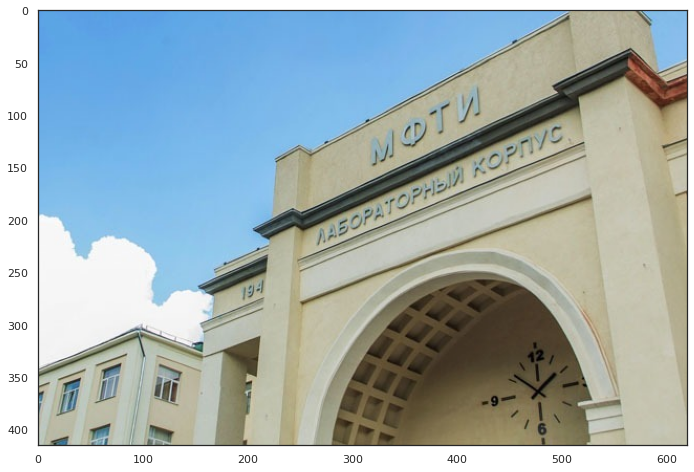

In [40]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуем посмотреть как различные свертки влияют на фото. Например, попробуем:

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

In [41]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]

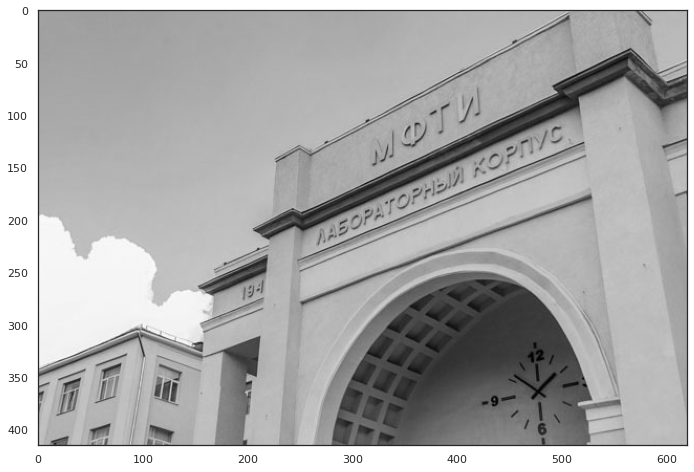

In [42]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

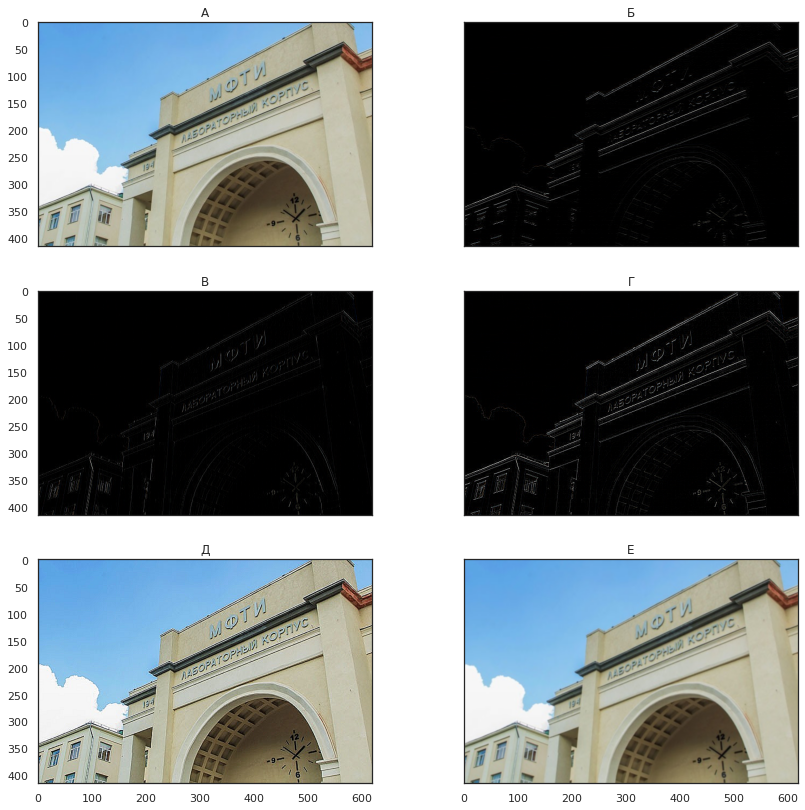

In [43]:
kernels = [
  np.array(([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
  ]), np.float32),

  np.array(([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
  ]), np.float32)
]

fig, axs = plt.subplots(nrows=3, ncols=2 ,
                        figsize=(14, 14),
                        sharey=True, sharex=True)

for pos, (kernel, ax) in enumerate(zip(kernels, axs.flatten())):
    ax.set_title(chr(ord('А') + pos))
    ax.imshow(cv2.filter2D(src=RGB_img, kernel=kernel, ddepth=-1))

Наблюдаем, что описать действия ядер, приведенных выше можно так:

1) Размытие - Е

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

### Реализуем LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуем архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используем модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из:

* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.

In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply layers created in __init__. 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучим CNN
Используем код обучения, который мы написали для полносвязной нейронной сети.

In [46]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train() # переводим модель в режим train
                optimizer.zero_grad() # обнуляем градиенты модели
                outp = model(x_batch)
            else:
                # Set model to ``eval`` mode and calculate outputs
                model.eval() # переводим модель в режим eval
                with torch.no_grad(): # НЕ считаем градиенты
                    outp = model(x_batch) # получаем "логиты" из модели
#             count_metrics(outp, y_batch) # считаем метрики
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch) # считаем "лосс" для логистической регрессии
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward() # считаем градиенты
                optimizer.step() # делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9542
Loader: valid. Accuracy: 0.9843
Epoch: 2
Loader: train. Accuracy: 0.9832833333333333
Loader: valid. Accuracy: 0.9831
Epoch: 3
Loader: train. Accuracy: 0.9876166666666667
Loader: valid. Accuracy: 0.989
Epoch: 4
Loader: train. Accuracy: 0.9903833333333333
Loader: valid. Accuracy: 0.9879
Epoch: 5
Loader: train. Accuracy: 0.9920166666666667
Loader: valid. Accuracy: 0.9881
Epoch: 6
Loader: train. Accuracy: 0.9932333333333333
Loader: valid. Accuracy: 0.9888
Epoch: 7
Loader: train. Accuracy: 0.99435
Loader: valid. Accuracy: 0.9886
Epoch: 8
Loader: train. Accuracy: 0.9951
Loader: valid. Accuracy: 0.9885
Epoch: 9
Loader: train. Accuracy: 0.9954333333333333
Loader: valid. Accuracy: 0.9885
Epoch: 10
Loader: train. Accuracy: 0.9959333333333333
Loader: valid. Accuracy: 0.988


In [47]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

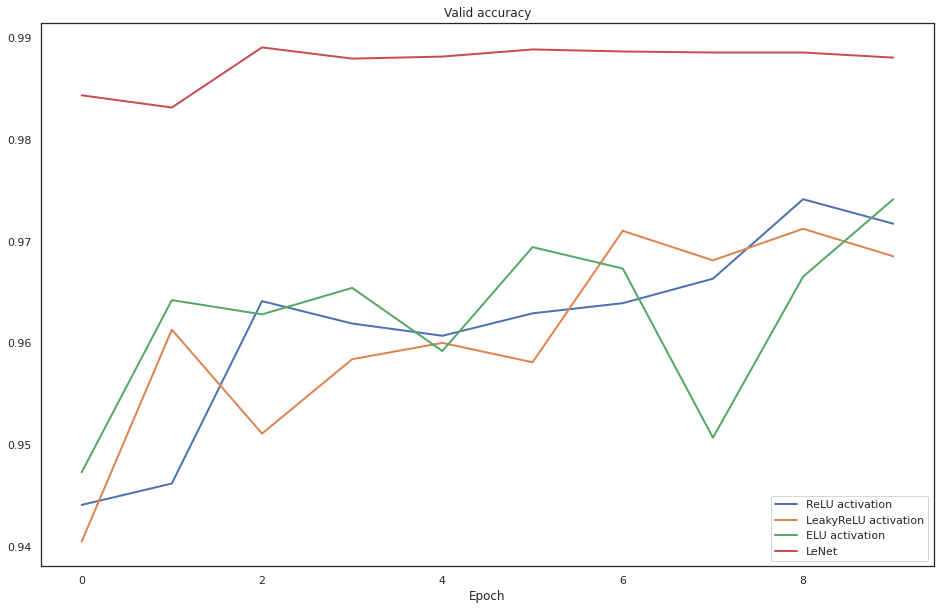

In [48]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Видим, что для работы с изображениями лучше подходят сверточные нейронные сети